In [31]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression




# Merge variables

In [29]:
# Define paths
data1_path = r"D:\File_auto\0_UCL_CASA\OneDrive - University College London\Xiaoyi_dissertation\Analysis\Data_output"
data2_path = r"D:\File_auto\0_UCL_CASA\OneDrive - University College London\Xiaoyi_dissertation\Analysis\Data\dfl_traffic_count"
data3_path = r"D:\File_auto\0_UCL_CASA\OneDrive - University College London\Xiaoyi_dissertation\Analysis\Data\tfl_crowding_data"

regions = ['Camden', 'City of London', 'Islington', 'Kensington and Chelsea', 'Lambeth', 'Southwark', 'Westminster']

## Each region

In [31]:
# Function to read CSV files containing region name in their names and merge them based on 'Date'
def read_and_merge_data1(folder_path, region):
    subfolders = ["NO_weighted", "NO2_weighted", "PM10_weighted", "PM25_weighted"]
    merged_df = pd.DataFrame()

    for subfolder in subfolders:
        subfolder_path = os.path.join(folder_path, subfolder)
        for root, dirs, files in os.walk(subfolder_path):
            for file in files:
                if file.endswith('.csv') and region in file:
                    file_path = os.path.join(root, file)
                    df = pd.read_csv(file_path)
                    air_type = subfolder.split('_')[0]
                    df.rename(columns={f"{air_type}_weighted_value(ug m-3)": f"{air_type}_value"}, inplace=True)
                    df['Date'] = df['Date'].str.strip()  # Remove leading/trailing spaces
                    df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d', errors='coerce')  # Handle invalid dates
                    if merged_df.empty:
                        merged_df = df
                    else:
                        merged_df = pd.merge(merged_df, df[['Date', f"{air_type}_value"]], on='Date', how='outer')
    return merged_df

# Function to read CSV files containing region name in their names from data2 and merge with data1
def read_and_merge_data2(data1_df, folder_path, region):
    columns_of_interest = [
        'pedal_cycles', 'two_wheeled_motor_vehicles', 'cars_and_taxis', 'buses_and_coaches', 'lgvs',
        'hgvs_2_rigid_axle', 'hgvs_3_rigid_axle', 'hgvs_4_or_more_rigid_axle', 'hgvs_3_or_4_articulated_axle',
        'hgvs_5_articulated_axle', 'hgvs_6_articulated_axle'
    ]
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith('.csv') and region in file:
                file_path = os.path.join(root, file)
                df = pd.read_csv(file_path)
                df['count_date'] = df['count_date'].str.strip()  # Remove leading/trailing spaces
                df['Date'] = pd.to_datetime(df['count_date'], format='%Y/%m/%d', errors='coerce')  # Handle invalid dates
                df_major = df[df['road_type'] == 'Major'][['Date'] + columns_of_interest].add_suffix('_major')
                df_minor = df[df['road_type'] == 'Minor'][['Date'] + columns_of_interest].add_suffix('_minor')
                df_major.rename(columns={'Date_major': 'Date'}, inplace=True)
                df_minor.rename(columns={'Date_minor': 'Date'}, inplace=True)
                data1_df = pd.merge(data1_df, df_major, on='Date', how='left')
                data1_df = pd.merge(data1_df, df_minor, on='Date', how='left')
    return data1_df

# Function to read CSV files from data3, filter by 'Borough' == region, and merge with data1
def read_and_merge_data3(data1_df, folder_path, region):
    all_years_df = pd.DataFrame()
    for year in range(2019, 2025):
        file_name = f"filtered_StationFootfall_{year}_merged.csv"
        file_path = os.path.join(folder_path, file_name)
        if os.path.exists(file_path):
            df = pd.read_csv(file_path)
            df = df[df['Borough'] == region]
            try:
                df['TravelDate'] = df['TravelDate'].astype(str).str.strip()  # Remove leading/trailing spaces
                df['TravelDate'] = pd.to_datetime(df['TravelDate'], format='%Y%m%d', errors='coerce')  # Handle invalid dates
            except ValueError:
                df['TravelDate'] = pd.to_datetime(df['TravelDate'], errors='coerce')
            df = df[['TravelDate', 'EntryTapCount', 'ExitTapCount']]
            all_years_df = pd.concat([all_years_df, df])
    all_years_df = all_years_df.groupby('TravelDate').sum().reset_index()
    data1_df = pd.merge(data1_df, all_years_df, left_on='Date', right_on='TravelDate', how='left')
    data1_df.drop(columns=['TravelDate'], inplace=True)
    return data1_df


# Process each region and save the merged data
for region in regions:
    data1_merged = read_and_merge_data1(data1_path, region)
    data1_merged = read_and_merge_data2(data1_merged, data2_path, region)
    final_merged_data = read_and_merge_data3(data1_merged, data3_path, region)
    
    output_path = f"D:\\File_auto\\0_UCL_CASA\\OneDrive - University College London\\Xiaoyi_dissertation\\Analysis\\Data_output\\Correlation\\{region}_corr_merged.csv"
    final_merged_data.to_csv(output_path, index=False)
    print(f"Data for {region} merged and saved successfully.")

Data for Camden merged and saved successfully.
Data for City of London merged and saved successfully.
Data for Islington merged and saved successfully.
Data for Kensington and Chelsea merged and saved successfully.
Data for Lambeth merged and saved successfully.
Data for Southwark merged and saved successfully.
Data for Westminster merged and saved successfully.


## all regions merged

In [32]:
# Concatenate all region files into one final file
all_regions_df = pd.DataFrame()
for region in regions:
    file_path = f"D:\\File_auto\\0_UCL_CASA\\OneDrive - University College London\\Xiaoyi_dissertation\\Analysis\\Data_output\\Correlation\\{region}_corr_merged.csv"
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        df['Region'] = region
        all_regions_df = pd.concat([all_regions_df, df])

final_output_path = r"D:\File_auto\0_UCL_CASA\OneDrive - University College London\Xiaoyi_dissertation\Analysis\Data_output\Correlation\corr_merged.csv"
all_regions_df.to_csv(final_output_path, index=False)

print("All regions data merged and saved successfully.")

All regions data merged and saved successfully.


# Correlation

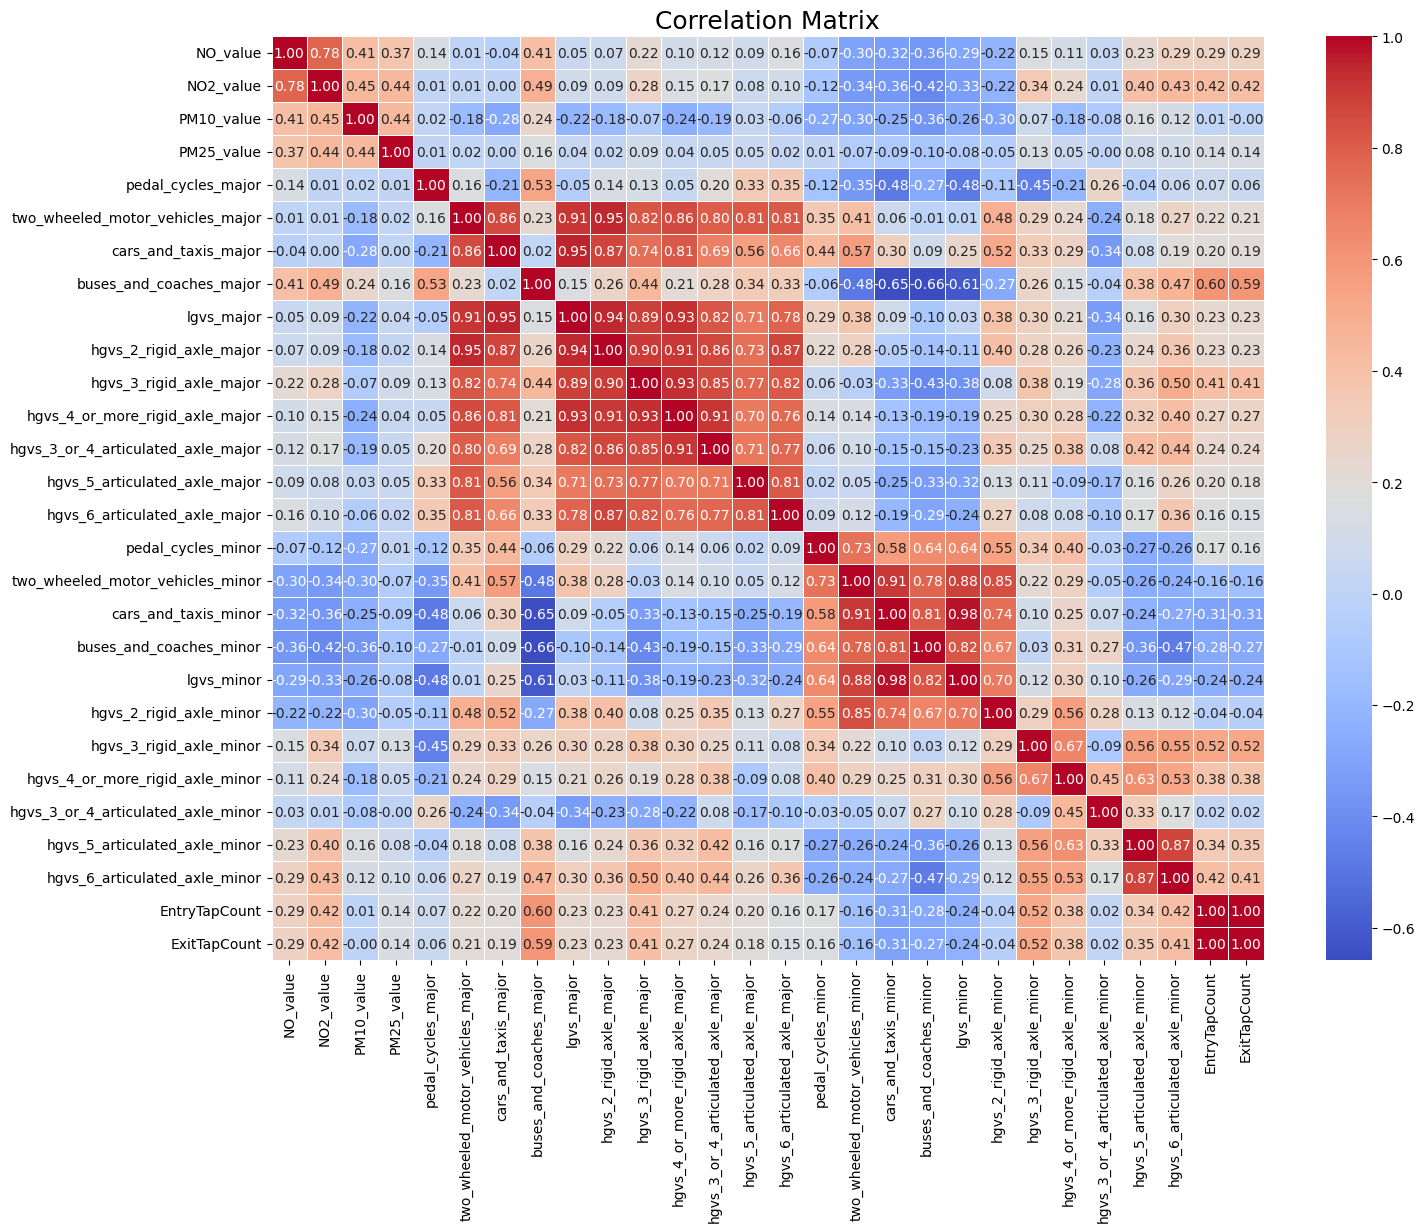

In [13]:

# 读取CSV文件
file_path = 'D:\\File_auto\\0_UCL_CASA\\OneDrive - University College London\\Xiaoyi_dissertation\\Analysis\\Data_output\\Correlation\\corr_merged.csv'
df = pd.read_csv(file_path)

# 选择指定的列
columns = [
    'NO_value', 'NO2_value', 'PM10_value', 'PM25_value', 'pedal_cycles_major',
    'two_wheeled_motor_vehicles_major', 'cars_and_taxis_major', 'buses_and_coaches_major',
    'lgvs_major', 'hgvs_2_rigid_axle_major', 'hgvs_3_rigid_axle_major', 'hgvs_4_or_more_rigid_axle_major',
    'hgvs_3_or_4_articulated_axle_major', 'hgvs_5_articulated_axle_major', 'hgvs_6_articulated_axle_major',
    'pedal_cycles_minor', 'two_wheeled_motor_vehicles_minor', 'cars_and_taxis_minor', 'buses_and_coaches_minor',
    'lgvs_minor', 'hgvs_2_rigid_axle_minor', 'hgvs_3_rigid_axle_minor', 'hgvs_4_or_more_rigid_axle_minor',
    'hgvs_3_or_4_articulated_axle_minor', 'hgvs_5_articulated_axle_minor', 'hgvs_6_articulated_axle_minor',
    'EntryTapCount', 'ExitTapCount'
]
df_selected = df[columns]

# 清除NaN值
df_selected = df_selected.dropna()

# 计算相关矩阵
corr_matrix = df_selected.corr()

# 绘制相关矩阵的热图
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix', fontsize=18)
plt.show()

In [ ]:
# corr_matrix

## all corr_matrix

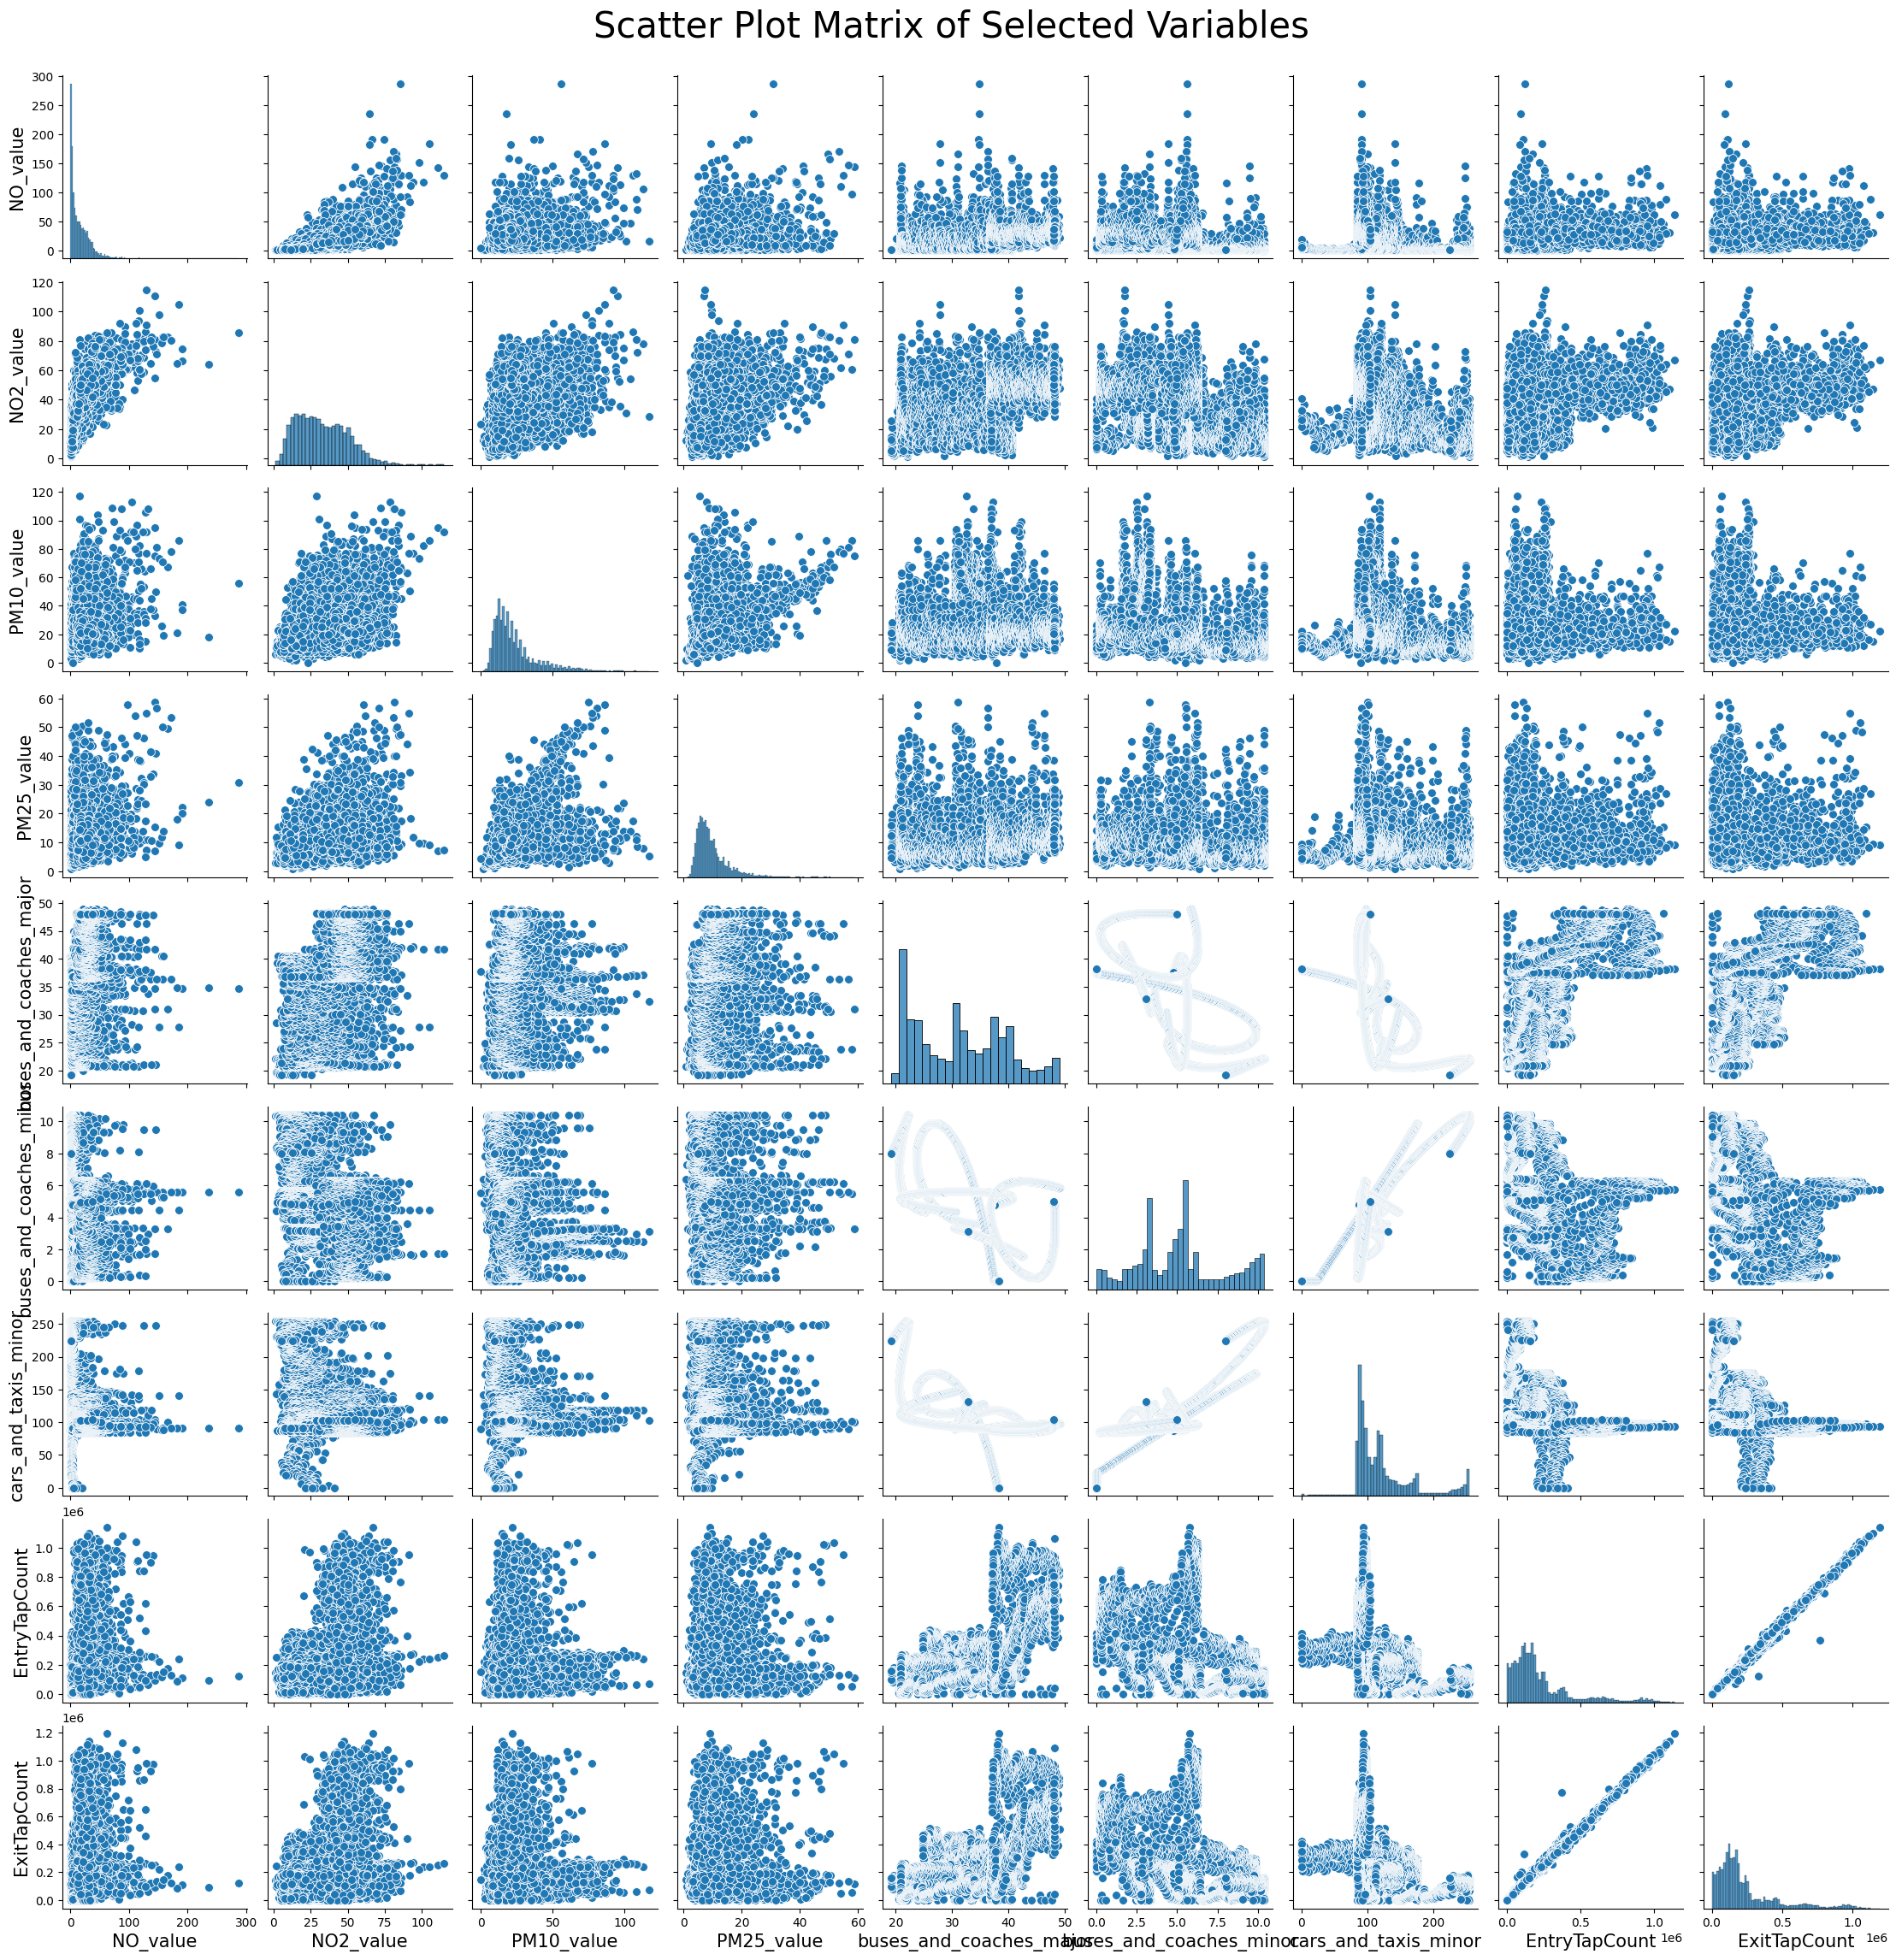

In [18]:
# 绘制散点图矩阵
# 选择指定的列
scat_columns = [
    'NO_value', 'NO2_value', 'PM10_value', 'PM25_value', 'buses_and_coaches_major',
    'buses_and_coaches_minor', 'cars_and_taxis_minor', 'EntryTapCount', 'ExitTapCount'
]
df_scat = df[scat_columns]

# 清除NaN值
df_scat = df_scat.dropna()

# 绘制散点图矩阵
pairplot = sns.pairplot(df_scat, plot_kws={'s': 50})  # 调整散点图点的大小
pairplot.fig.suptitle('Scatter Plot Matrix of Selected Variables', y=1.02, fontsize=30)  # 添加标题

# 调整变量字体大小
for ax in pairplot.axes.flatten():
    ax.set_xlabel(ax.get_xlabel(), fontsize=15)
    ax.set_ylabel(ax.get_ylabel(), fontsize=15)
plt.show()

## each corr_matrix

In [ ]:
# # 选择指定的列
# columns = [
#     'NO_value', 'NO2_value', 'PM10_value', 'PM25_value', 'pedal_cycles_major',
#     'two_wheeled_motor_vehicles_major', 'cars_and_taxis_major', 'buses_and_coaches_major',
#     'lgvs_major', 'hgvs_2_rigid_axle_major', 'hgvs_3_rigid_axle_major', 'hgvs_4_or_more_rigid_axle_major',
#     'hgvs_3_or_4_articulated_axle_major', 'hgvs_5_articulated_axle_major', 'hgvs_6_articulated_axle_major',
#     'pedal_cycles_minor', 'two_wheeled_motor_vehicles_minor', 'cars_and_taxis_minor', 'buses_and_coaches_minor',
#     'lgvs_minor', 'hgvs_2_rigid_axle_minor', 'hgvs_3_rigid_axle_minor', 'hgvs_4_or_more_rigid_axle_minor',
#     'hgvs_3_or_4_articulated_axle_minor', 'hgvs_5_articulated_axle_minor', 'hgvs_6_articulated_axle_minor',
#     'EntryTapCount', 'ExitTapCount'
# ]

# regions = ['Camden', 'City of London', 'Islington', 'Kensington and Chelsea', 'Lambeth', 'Southwark', 'Westminster']

# for region in regions:
#     # 构建文件路径
#     output_path = f"D:\\File_auto\\0_UCL_CASA\\OneDrive - University College London\\Xiaoyi_dissertation\\Analysis\\Data_output\\Correlation\\{region}_corr_merged.csv"
    
#     # 读取数据
#     df_region = pd.read_csv(output_path)
    
#     # 对于Westminster、City of London和Islington区域，去除minor类型的列
#     if region in ['Westminster', 'City of London', 'Islington']:
#         columns_to_use = [col for col in columns if 'minor' not in col]
#     else:
#         columns_to_use = columns
    
#     # 选择指定的列
#     df_region = df_region[columns_to_use]
    
#     # 清除NaN值
#     df_region = df_region.dropna()
    
#     # 计算相关矩阵
#     corr_matrix = df_region.corr()
    
#     # 绘制相关矩阵
#     plt.figure(figsize=(16, 12))
#     sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
#     plt.title(f'Correlation Matrix for {region}', fontsize=16)
#     plt.show()



# Multiple Linear regression

## 单个线性回归模型

In [30]:


# 选择指定的列
scat_columns = [
    'NO_value', 'NO2_value', 'PM10_value', 'PM25_value', 'buses_and_coaches_major',
    'buses_and_coaches_minor', 'cars_and_taxis_minor', 'EntryTapCount', 'ExitTapCount'
]
df_scat = df[scat_columns]

# 清除NaN值
df_scat = df_scat.dropna()

# 定义特征变量
X = df_scat[['buses_and_coaches_major', 'buses_and_coaches_minor', 'cars_and_taxis_minor', 'EntryTapCount', 'ExitTapCount']]

# 添加常数项
X = sm.add_constant(X)

# 目标变量列表
y_columns = ['NO_value', 'NO2_value', 'PM10_value', 'PM25_value']

# 对每个目标变量进行线性回归
for y_col in y_columns:
    y = df_scat[y_col]
    model = sm.OLS(y, X).fit()
    print(f"Linear Regression Results for {y_col}:")
    print(model.summary())
    print("\n")

Linear Regression Results for NO_value:
                            OLS Regression Results                            
Dep. Variable:               NO_value   R-squared:                       0.191
Model:                            OLS   Adj. R-squared:                  0.191
Method:                 Least Squares   F-statistic:                     400.1
Date:                Tue, 27 Aug 2024   Prob (F-statistic):               0.00
Time:                        09:41:42   Log-Likelihood:                -36272.
No. Observations:                8457   AIC:                         7.256e+04
Df Residuals:                    8451   BIC:                         7.260e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

## 多重线性回归模型

In [33]:
# 选择指定的列
scat_columns = [
    'NO_value', 'NO2_value', 'PM10_value', 'PM25_value', 'buses_and_coaches_major',
    'buses_and_coaches_minor', 'cars_and_taxis_minor', 'EntryTapCount', 'ExitTapCount'
]
df_scat = df[scat_columns]

# 清除NaN值
df_scat = df_scat.dropna()

# 定义特征变量
X = df_scat[['buses_and_coaches_major', 'buses_and_coaches_minor', 'cars_and_taxis_minor', 'EntryTapCount', 'ExitTapCount']]

# 目标变量
Y = df_scat[['NO_value', 'NO2_value', 'PM10_value', 'PM25_value']]

# 分割数据集
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# 定义多重线性回归模型
multi_target_model = MultiOutputRegressor(LinearRegression())

# 训练模型
multi_target_model.fit(X_train, Y_train)

# 预测
Y_pred = multi_target_model.predict(X_test)

# 打印结果
print("Multi-output Linear Regression Results:")
print("Predicted values:")
print(Y_pred)
print("Actual values:")
print(Y_test.values)

# 打印模型公式
feature_names = X.columns
target_names = Y.columns

for i, target in enumerate(target_names):
    coef = multi_target_model.estimators_[i].coef_
    intercept = multi_target_model.estimators_[i].intercept_
    formula = f"{target} = {intercept:.4f}"
    for j, feature in enumerate(feature_names):
        formula += f" + ({coef[j]:.4f} * {feature})"
    print(f"Formula for {target}:")
    print(formula)
    print()

Multi-output Linear Regression Results:
Predicted values:
[[ 6.44808971 21.37697439 19.34799153  8.51255178]
 [18.49552107 32.74064946 27.41641578  9.72177819]
 [ 7.08685469 23.36107495 15.54733012  8.78305209]
 ...
 [ 4.28189864 20.30034777 15.89690369  9.00882943]
 [13.73112973 29.74573125 23.07342881  9.30830405]
 [ 6.14868165 23.47098513 17.82160525  9.41099991]]
Actual values:
[[ 0.8         6.4         8.06041667  4.492     ]
 [83.9        70.1        93.         10.6       ]
 [ 3.65       24.375      11.9         5.26666667]
 ...
 [ 1.1        14.9        24.54166667 17.02445833]
 [ 2.2        12.         16.          7.925     ]
 [ 1.1         9.7        10.39583333  6.60383333]]
Formula for NO_value:
NO_value = 4.8144 + (0.5234 * buses_and_coaches_major) + (-1.3989 * buses_and_coaches_minor) + (0.0042 * cars_and_taxis_minor) + (0.0001 * EntryTapCount) + (-0.0001 * ExitTapCount)

Formula for NO2_value:
NO2_value = 20.1872 + (0.4291 * buses_and_coaches_major) + (-1.9009 * buses_